In [1]:
import geopandas
import pandas
import shapely

In [2]:
stations = geopandas.read_file("Subway Stations.geojson")
stations.set_index('objectid', inplace=True)
stations

,name,url,line,notes,geometry
objectid,,,,,
1,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-73.99107 40.73005)
2,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-74.00019 40.71880)
3,50th St,http://web.mta.info/nyct/service/,1-2,"1-all times, 2-nights",POINT (-73.98385 40.76173)
4,Bergen St,http://web.mta.info/nyct/service/,2-3-4,"4-nights, 3-all other times, 2-all times",POINT (-73.97500 40.68086)
5,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,"4-nights, 3-all other times",POINT (-73.89489 40.66471)
...,...,...,...,...,...
469,Coney Island - Stillwell Av,http://web.mta.info/nyct/service/,D-F-N-Q,"D,F,N,Q-all times",POINT (-73.98124 40.57728)
470,34th St - Hudson Yards,http://web.mta.info/nyct/service/,7-7 Express,"7-all times, 7 Express-rush hours AM westbound...",POINT (-74.00220 40.75545)
641,72nd St,http://web.mta.info/nyct/service/,Q,Q-all times,POINT (-73.95836 40.76880)


In [3]:
stations.explore()

In [4]:
from xml.etree import ElementTree
from svgpathtools import parse_path
from svgpathtools.path import transform
import numpy as np
import re
FLOAT_RE = r"([-+]?\d+(?:\.\d+)?)"
MATRIX_RE = re.compile(r"matrix\s*\(\s*" + r"\s*,\s*".join((FLOAT_RE,) * 6) + r"\s*\)")
subway_map_tree = ElementTree.parse("subway_map_annotated.svg")
subway_map_root = subway_map_tree.getroot()

stations['labeled'] = None
for elem in subway_map_root.iter('{http://www.w3.org/2000/svg}g'):
    if (name := elem.get('id')) is None or not name.startswith('station-'):
        continue
    good_elem = elem
    station_id = name[8:]
    a, b, c, d, e, f = (float(x) for x in MATRIX_RE.match(elem.get('transform')).groups())
    #stations.at[station_id, 'labeled'] = shapely.Point(e, -f)
    transform_matrix = np.array([[a, c, e], [b, d, f], [0, 0, 1]])
    path = transform(parse_path(elem[0].get('d')), transform_matrix)
    xmin, xmax, ymin, ymax = path.bbox()
    if stations.at[station_id, 'labeled'] is not None:
        raise ValueError(f"saw station #{station_id} more than once??")
    stations.at[station_id, 'labeled'] = shapely.Point((xmax + xmin) / 2, -(ymax + ymin) / 2)

In [5]:
unlabeled_stations = stations[stations['labeled'].isnull()]
print(f"{len(unlabeled_stations)}/{len(stations)}")
unlabeled_stations.explore(marker_kwds={'radius': 5}, tooltip=('objectid', 'name', 'line'), popup=('objectid', 'name', 'line'))

237/473


/Users/jessie/Library/Python/3.11/lib/python/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

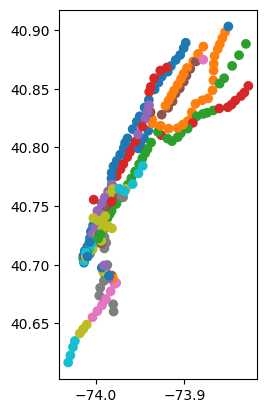

In [6]:
labeled_stations = stations[~stations['labeled'].isnull()]
labeled_stations.plot('line')

/Users/jessie/Library/Python/3.11/lib/python/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

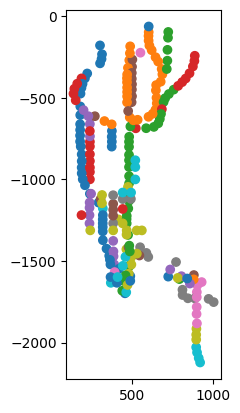

In [7]:
labeled_stations_mapped = labeled_stations.set_geometry('labeled')
labeled_stations_mapped.plot('line')

In [15]:
import json
def normalize(min_, max_, x):
    return (x - min_) / (max_ - min_)
def squarify(minx, miny, maxx, maxy):
    rangex = maxx - minx
    rangey = maxy - miny
    diff = abs(rangex - rangey)
    if rangey > rangex:
        return minx - diff/2, miny, maxx + diff/2, maxy
    else:
        return minx, miny - diff/2, maxx, maxy + diff/2
def browser_data(stations):
    point_to_idx = {(pt.x, pt.y): i for i, pt in enumerate(stations['geometry'])}
    station_mp = shapely.MultiPoint(stations['geometry'].array)
    minx, miny, maxx, maxy = squarify(*shapely.MultiPoint(stations['labeled'].array).bounds)
    tris = shapely.delaunay_triangles(station_mp)
    return {
        'input_crs': stations.crs.name,
        'vertices': [
            (st['geometry'].x,
             st['geometry'].y,
             normalize(minx, maxx, st['labeled'].x),
             normalize(miny, maxy, st['labeled'].y))
            for _, st
            in stations.iterrows()
        ],
        'triangles': [[point_to_idx[pt] for pt in list(poly.exterior.coords)[:-1]] for poly in tris.geoms]
    }
spec = browser_data(labeled_stations)
with open("data.json", 'w') as f:
    json.dump(spec, f)

In [12]:
shapely.MultiPoint(labeled_stations['labeled'].array).bounds

(142.0, -2122.3900083, 1001.710666665, -61.64504255499999)

In [79]:
station_mp = shapely.MultiPoint(labeled_stations['geometry'].array)
buffered = station_mp.buffer(0.1)
bounds = shapely.geometry.box(*buffered.bounds)
denser = bounds.segmentize(0.1)
list(denser.exterior.coords)

[(-73.72812100059289, 40.727904998845844),
 (-73.72812100059289, 40.819644999410976),
 (-73.72812100059289, 40.911384999976114),
 (-73.72812100059289, 41.003125000541246),
 (-73.8061240002128, 41.003125000541246),
 (-73.88412699983273, 41.003125000541246),
 (-73.96212999945266, 41.003125000541246),
 (-74.04013299907257, 41.003125000541246),
 (-74.04013299907257, 40.911384999976114),
 (-74.04013299907257, 40.819644999410976),
 (-74.04013299907257, 40.727904998845844),
 (-73.96212999945266, 40.727904998845844),
 (-73.88412699983273, 40.727904998845844),
 (-73.8061240002128, 40.727904998845844),
 (-73.72812100059289, 40.727904998845844)]

In [ ]:
[1, 2, 3, 4][:-1]

In [41]:
import pyproj
mta_trans = pyproj.Transformer.from_pipeline(mta_crs)

In [42]:
mta_trans.has_inverse

True